In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture  # We'll keep this for comparison
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

In [18]:
# Load the digits dataset
digits = load_digits()
X = digits.data
y = digits.target

print(f"Original dataset shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Classes: {np.unique(y)}")

Original dataset shape: (1797, 64)
Number of classes: 10
Classes: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
# Select only digits 0, 1, and 2
selected_digits = [0, 1, 2]
mask = np.isin(y, selected_digits)
X_selected = X[mask]
y_selected = y[mask]

print(f"Selected dataset shape: {X_selected.shape}")
print(f"Selected classes: {np.unique(y_selected)}")
print(f"Class distribution:")
for digit in selected_digits:
    count = np.sum(y_selected == digit)
    print(f"  Digit {digit}: {count} samples")

# Visualize some sample digits
fig, axes = plt.subplots(2, 6, figsize=(12, 4))
for i, digit in enumerate(selected_digits):
    digit_indices = np.where(y_selected == digit)[0][:4]  # First 4 samples of each digit
    for j, idx in enumerate(digit_indices):
        row = j // 2
        col = i * 2 + j % 2
        axes[row, col].imshow(X_selected[idx].reshape(8, 8), cmap='gray')
        axes[row, col].set_title(f'Digit {digit}')
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

Selected dataset shape: (537, 64)
Selected classes: [0 1 2]
Class distribution:
  Digit 0: 178 samples
  Digit 1: 182 samples
  Digit 2: 177 samples


PCA-transformed data shape: (537, 2)
Explained variance ratio: [0.2336749  0.15603256]
Total variance explained: 0.390


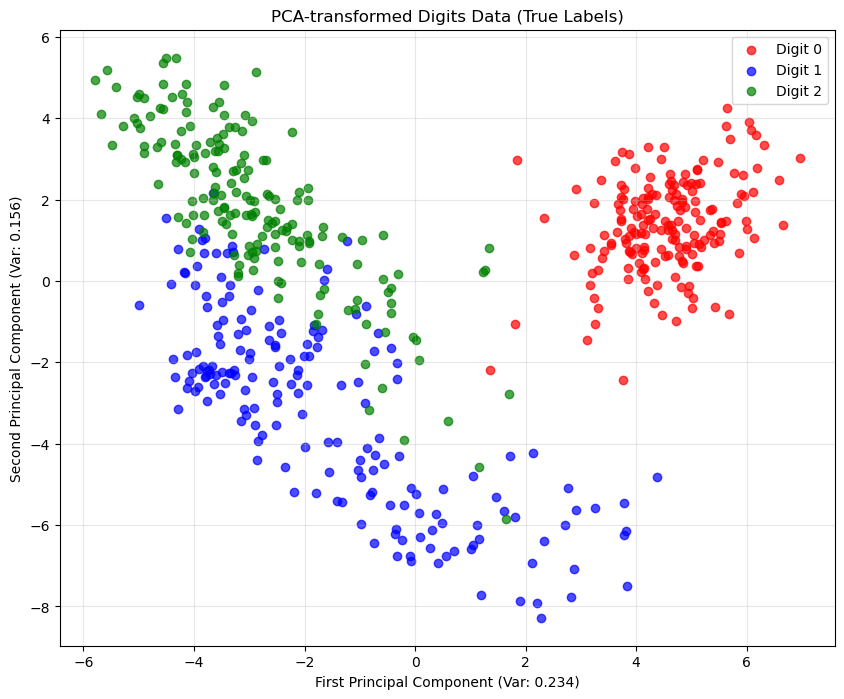

In [4]:
# Standardize the data before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA-transformed data shape: {X_pca.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")

# Plot the PCA-transformed data colored by true labels
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green']
for i, digit in enumerate(selected_digits):
    mask = y_selected == digit
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=colors[i], label=f'Digit {digit}', alpha=0.7)
plt.xlabel(f'First Principal Component (Var: {pca.explained_variance_ratio_[0]:.3f})')
plt.ylabel(f'Second Principal Component (Var: {pca.explained_variance_ratio_[1]:.3f})')
plt.title('PCA-transformed Digits Data (True Labels)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [5]:
# Run K-Means with k=3 (since we have 3 classes)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_pca)

print(f"K-Means cluster centers:\n{kmeans.cluster_centers_}")
print(f"K-Means inertia: {kmeans.inertia_:.2f}")

K-Means cluster centers:
[[ 4.49824615  1.37696383]
 [-1.10217405 -3.57321262]
 [-3.36417497  2.01256682]]
K-Means inertia: 2489.11


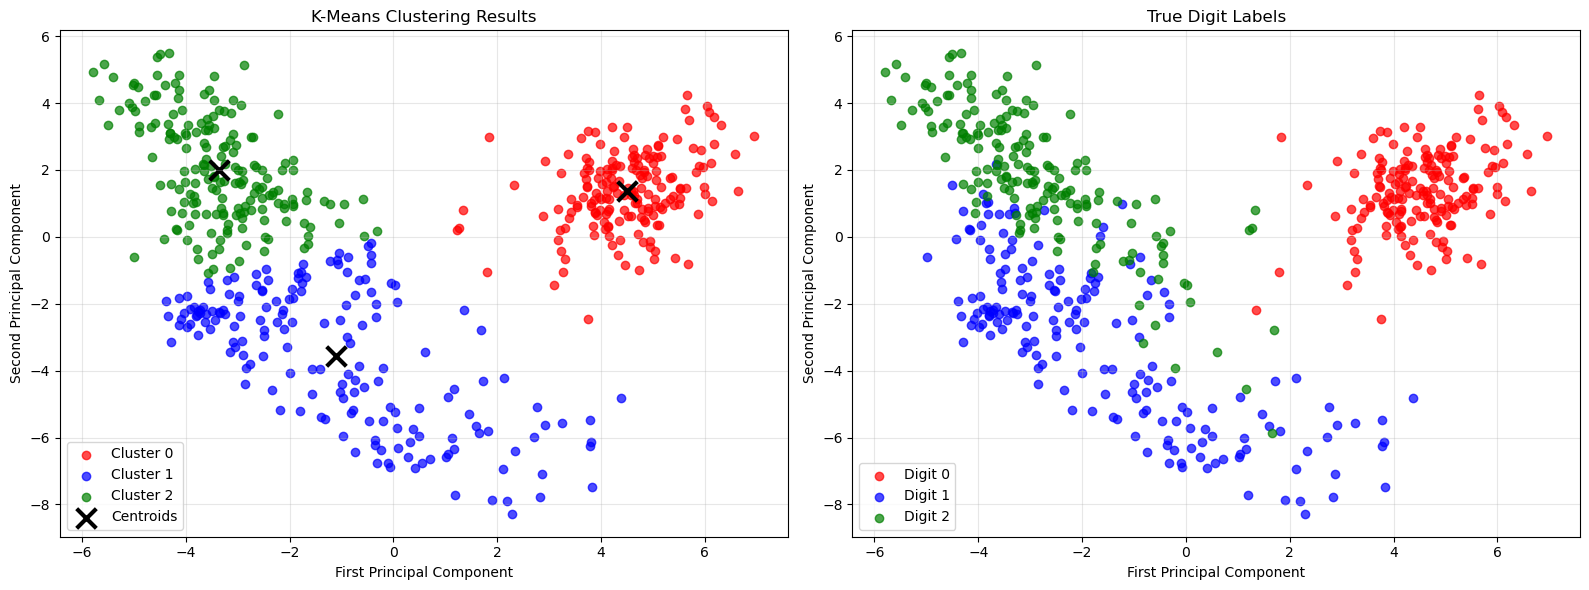

K-Means clustering accuracy: 0.892


In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot K-Means clusters
colors_kmeans = ['red', 'blue', 'green']
for i in range(3):
    mask = kmeans_labels == i
    ax1.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=colors_kmeans[i], label=f'Cluster {i}', alpha=0.7)

# Plot cluster centers
ax1.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
           c='black', marker='x', s=200, linewidths=3, label='Centroids')
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
ax1.set_title('K-Means Clustering Results')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot original labels for comparison
colors_true = ['red', 'blue', 'green']
for i, digit in enumerate(selected_digits):
    mask = y_selected == digit
    ax2.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=colors_true[i], label=f'Digit {digit}', alpha=0.7)
ax2.set_xlabel('First Principal Component')
ax2.set_ylabel('Second Principal Component')
ax2.set_title('True Digit Labels')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate clustering accuracy (best possible mapping)
from scipy.optimize import linear_sum_assignment

def clustering_accuracy(y_true, y_pred):
    """Calculate clustering accuracy using the Hungarian algorithm"""
    # Create confusion matrix
    n_clusters = len(np.unique(y_pred))
    n_classes = len(np.unique(y_true))
    confusion_matrix = np.zeros((n_clusters, n_classes))
    
    for i in range(n_clusters):
        for j in range(n_classes):
            confusion_matrix[i, j] = np.sum((y_pred == i) & (y_true == j))
    
    # Use Hungarian algorithm to find best assignment
    row_ind, col_ind = linear_sum_assignment(-confusion_matrix)
    accuracy = confusion_matrix[row_ind, col_ind].sum() / len(y_true)
    return accuracy

accuracy = clustering_accuracy(y_selected, kmeans_labels)
print(f"K-Means clustering accuracy: {accuracy:.3f}")

Optimal k based on elbow method: 2


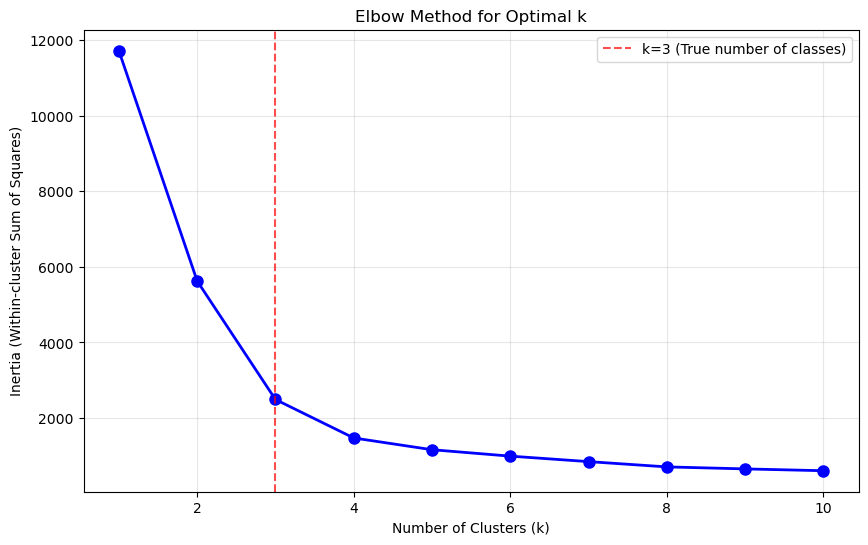

Inertia values for different k:
k=1: 11719.28
k=2: 5624.72
k=3: 2489.11
k=4: 1471.07
k=5: 1159.94
k=6: 990.10
k=7: 845.06
k=8: 705.31
k=9: 652.23
k=10: 604.09


In [7]:
# Test different values of k
k_range = range(1, 11)
inertias = []

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_pca)
    inertias.append(kmeans_temp.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)

# Highlight k=3
plt.axvline(x=3, color='red', linestyle='--', alpha=0.7, label='k=3 (True number of classes)')
plt.legend()

# Calculate elbow score (second derivative)
if len(inertias) >= 3:
    elbow_scores = []
    for i in range(1, len(inertias)-1):
        elbow_score = inertias[i-1] - 2*inertias[i] + inertias[i+1]
        elbow_scores.append(elbow_score)
    
    optimal_k = np.argmax(elbow_scores) + 2  # +2 because we start from index 1
    print(f"Optimal k based on elbow method: {optimal_k}")

plt.show()

# Print inertia values
print("Inertia values for different k:")
for k, inertia in zip(k_range, inertias):
    print(f"k={k}: {inertia:.2f}")

In [8]:
class GaussianMixtureModel:
    """
    From-scratch implementation of Gaussian Mixture Model using EM algorithm
    """
    def __init__(self, n_components=3, covariance_type='full', max_iter=100, 
                 tol=1e-3, random_state=None):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        
        # Initialize parameters
        self.weights_ = None
        self.means_ = None
        self.covariances_ = None
        self.log_likelihoods_ = []
        self.converged_ = False
        self.n_iter_ = 0
        
    def _initialize_parameters(self, X):
        """Initialize GMM parameters using K-means++ style initialization"""
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        
        # Initialize weights uniformly
        self.weights_ = np.ones(self.n_components) / self.n_components
        
        # Better initialization using K-means++ style
        # First center is random
        self.means_ = np.zeros((self.n_components, n_features))
        self.means_[0] = X[np.random.randint(n_samples)]
        
        # Choose remaining centers with probability proportional to squared distance
        for k in range(1, self.n_components):
            distances = np.array([min([np.linalg.norm(x - self.means_[j])**2 
                                     for j in range(k)]) for x in X])
            probabilities = distances / distances.sum()
            cumulative_probabilities = probabilities.cumsum()
            r = np.random.rand()
            chosen_idx = np.searchsorted(cumulative_probabilities, r)
            self.means_[k] = X[chosen_idx]
        
        # Initialize covariances more conservatively
        if self.covariance_type == 'full':
            # Use global covariance scaled down
            global_cov = np.cov(X.T)
            self.covariances_ = np.array([global_cov * 0.1 for _ in range(self.n_components)])
        elif self.covariance_type == 'diag':
            # Use global variances scaled down
            global_var = np.var(X, axis=0)
            self.covariances_ = np.array([global_var * 0.1 for _ in range(self.n_components)])
        
        # Add regularization
        if self.covariance_type == 'full':
            for k in range(self.n_components):
                self.covariances_[k] += np.eye(n_features) * 1e-6
        else:
            self.covariances_ += 1e-6
    
    def _log_multivariate_gaussian(self, X, mean, cov):
        """Calculate log of multivariate Gaussian probability density for numerical stability"""
        n_features = X.shape[1]
        diff = X - mean
        
        if self.covariance_type == 'full':
            # Full covariance
            try:
                cov_chol = np.linalg.cholesky(cov)
                cov_logdet = 2 * np.sum(np.log(np.diag(cov_chol)))
                
                # Solve using Cholesky decomposition for numerical stability
                solved = np.linalg.solve(cov_chol, diff.T).T
                mahalanobis_sq = np.sum(solved * solved, axis=1)
                
            except np.linalg.LinAlgError:
                # Fallback to regular inverse if Cholesky fails
                cov_inv = np.linalg.inv(cov + np.eye(n_features) * 1e-6)
                cov_logdet = np.log(np.linalg.det(cov + np.eye(n_features) * 1e-6))
                mahalanobis_sq = np.sum(diff @ cov_inv * diff, axis=1)
                
        elif self.covariance_type == 'diag':
            # Diagonal covariance
            cov_logdet = np.sum(np.log(cov + 1e-10))
            mahalanobis_sq = np.sum((diff ** 2) / (cov + 1e-10), axis=1)
        
        # Log probability density
        log_prob = -0.5 * (n_features * np.log(2 * np.pi) + cov_logdet + mahalanobis_sq)
        
        return log_prob
    
    def _e_step(self, X):
        """Expectation step: calculate responsibilities"""
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        log_probs = np.zeros((n_samples, self.n_components))
        
        # Calculate log probabilities for numerical stability
        for k in range(self.n_components):
            log_probs[:, k] = (np.log(self.weights_[k] + 1e-10) + 
                              self._log_multivariate_gaussian(X, self.means_[k], 
                                                             self.covariances_[k]))
        
        # Use log-sum-exp trick for numerical stability
        max_log_prob = np.max(log_probs, axis=1, keepdims=True)
        log_probs_normalized = log_probs - max_log_prob
        probs_normalized = np.exp(log_probs_normalized)
        
        # Calculate responsibilities
        total_prob = np.sum(probs_normalized, axis=1, keepdims=True)
        responsibilities = probs_normalized / (total_prob + 1e-10)
        
        # Calculate log-likelihood properly
        log_likelihood = np.sum(max_log_prob.flatten() + np.log(total_prob.flatten() + 1e-10))
        
        return responsibilities, log_likelihood
    
    def _m_step(self, X, responsibilities):
        """Maximization step: update parameters"""
        n_samples, n_features = X.shape
        
        # Calculate effective number of points for each component
        N_k = np.sum(responsibilities, axis=0)
        
        # Update weights
        self.weights_ = N_k / n_samples
        
        # Update means
        for k in range(self.n_components):
            if N_k[k] > 0:
                self.means_[k] = np.sum(responsibilities[:, k:k+1] * X, axis=0) / N_k[k]
        
        # Update covariances
        for k in range(self.n_components):
            if N_k[k] > 0:
                diff = X - self.means_[k]
                
                if self.covariance_type == 'full':
                    # Full covariance matrix
                    weighted_diff = responsibilities[:, k:k+1] * diff
                    self.covariances_[k] = (weighted_diff.T @ diff) / N_k[k]
                    # Add regularization
                    self.covariances_[k] += np.eye(n_features) * 1e-6
                    
                elif self.covariance_type == 'diag':
                    # Diagonal covariance
                    self.covariances_[k] = np.sum(responsibilities[:, k:k+1] * (diff ** 2), axis=0) / N_k[k]
                    # Add regularization
                    self.covariances_[k] += 1e-6
    
    def fit(self, X):
        """Fit the GMM using EM algorithm"""
        self._initialize_parameters(X)
        self.log_likelihoods_ = []
        
        prev_log_likelihood = -np.inf
        
        for iteration in range(self.max_iter):
            # E-step
            responsibilities, log_likelihood = self._e_step(X)
            # Store per-sample log-likelihood for consistency with sklearn
            per_sample_log_likelihood = log_likelihood / len(X)
            self.log_likelihoods_.append(per_sample_log_likelihood)
            
            # M-step
            self._m_step(X, responsibilities)
            
            # Check for convergence (using total log-likelihood for comparison)
            if abs(log_likelihood - prev_log_likelihood) < self.tol * len(X):
                self.converged_ = True
                break
                
            prev_log_likelihood = log_likelihood
        
        self.n_iter_ = iteration + 1
        return self
    
    def predict(self, X):
        """Predict cluster labels"""
        responsibilities, _ = self._e_step(X)
        return np.argmax(responsibilities, axis=1)
    
    def predict_proba(self, X):
        """Predict cluster probabilities"""
        responsibilities, _ = self._e_step(X)
        return responsibilities
    
    def score(self, X):
        """Calculate per-sample log-likelihood of the data (like sklearn)"""
        _, total_log_likelihood = self._e_step(X)
        return total_log_likelihood / len(X)

In [9]:
print("Running custom GMM implementation...")

# Run custom GMM with 'full' covariance
print("Fitting GMM with full covariance...")
custom_gmm_full = GaussianMixtureModel(n_components=3, covariance_type='full', 
                                      max_iter=100, random_state=42)
custom_gmm_full.fit(X_pca)
custom_gmm_full_labels = custom_gmm_full.predict(X_pca)

# Run custom GMM with 'diag' covariance  
print("Fitting GMM with diagonal covariance...")
custom_gmm_diag = GaussianMixtureModel(n_components=3, covariance_type='diag', 
                                      max_iter=100, random_state=42)
custom_gmm_diag.fit(X_pca)
custom_gmm_diag_labels = custom_gmm_diag.predict(X_pca)

print("\nCustom GMM with 'full' covariance:")
print(f"  Converged: {custom_gmm_full.converged_}")
print(f"  Number of iterations: {custom_gmm_full.n_iter_}")
print(f"  Final log-likelihood: {custom_gmm_full.log_likelihoods_[-1]:.2f}")
print(f"  Weights: {custom_gmm_full.weights_}")

print("\nCustom GMM with 'diag' covariance:")
print(f"  Converged: {custom_gmm_diag.converged_}")
print(f"  Number of iterations: {custom_gmm_diag.n_iter_}")
print(f"  Final log-likelihood: {custom_gmm_diag.log_likelihoods_[-1]:.2f}")
print(f"  Weights: {custom_gmm_diag.weights_}")

Running custom GMM implementation...
Fitting GMM with full covariance...
Fitting GMM with diagonal covariance...

Custom GMM with 'full' covariance:
  Converged: True
  Number of iterations: 16
  Final log-likelihood: -4.35
  Weights: [0.41871645 0.33525106 0.24603248]

Custom GMM with 'diag' covariance:
  Converged: True
  Number of iterations: 8
  Final log-likelihood: -4.45
  Weights: [0.48283464 0.32267085 0.19449451]


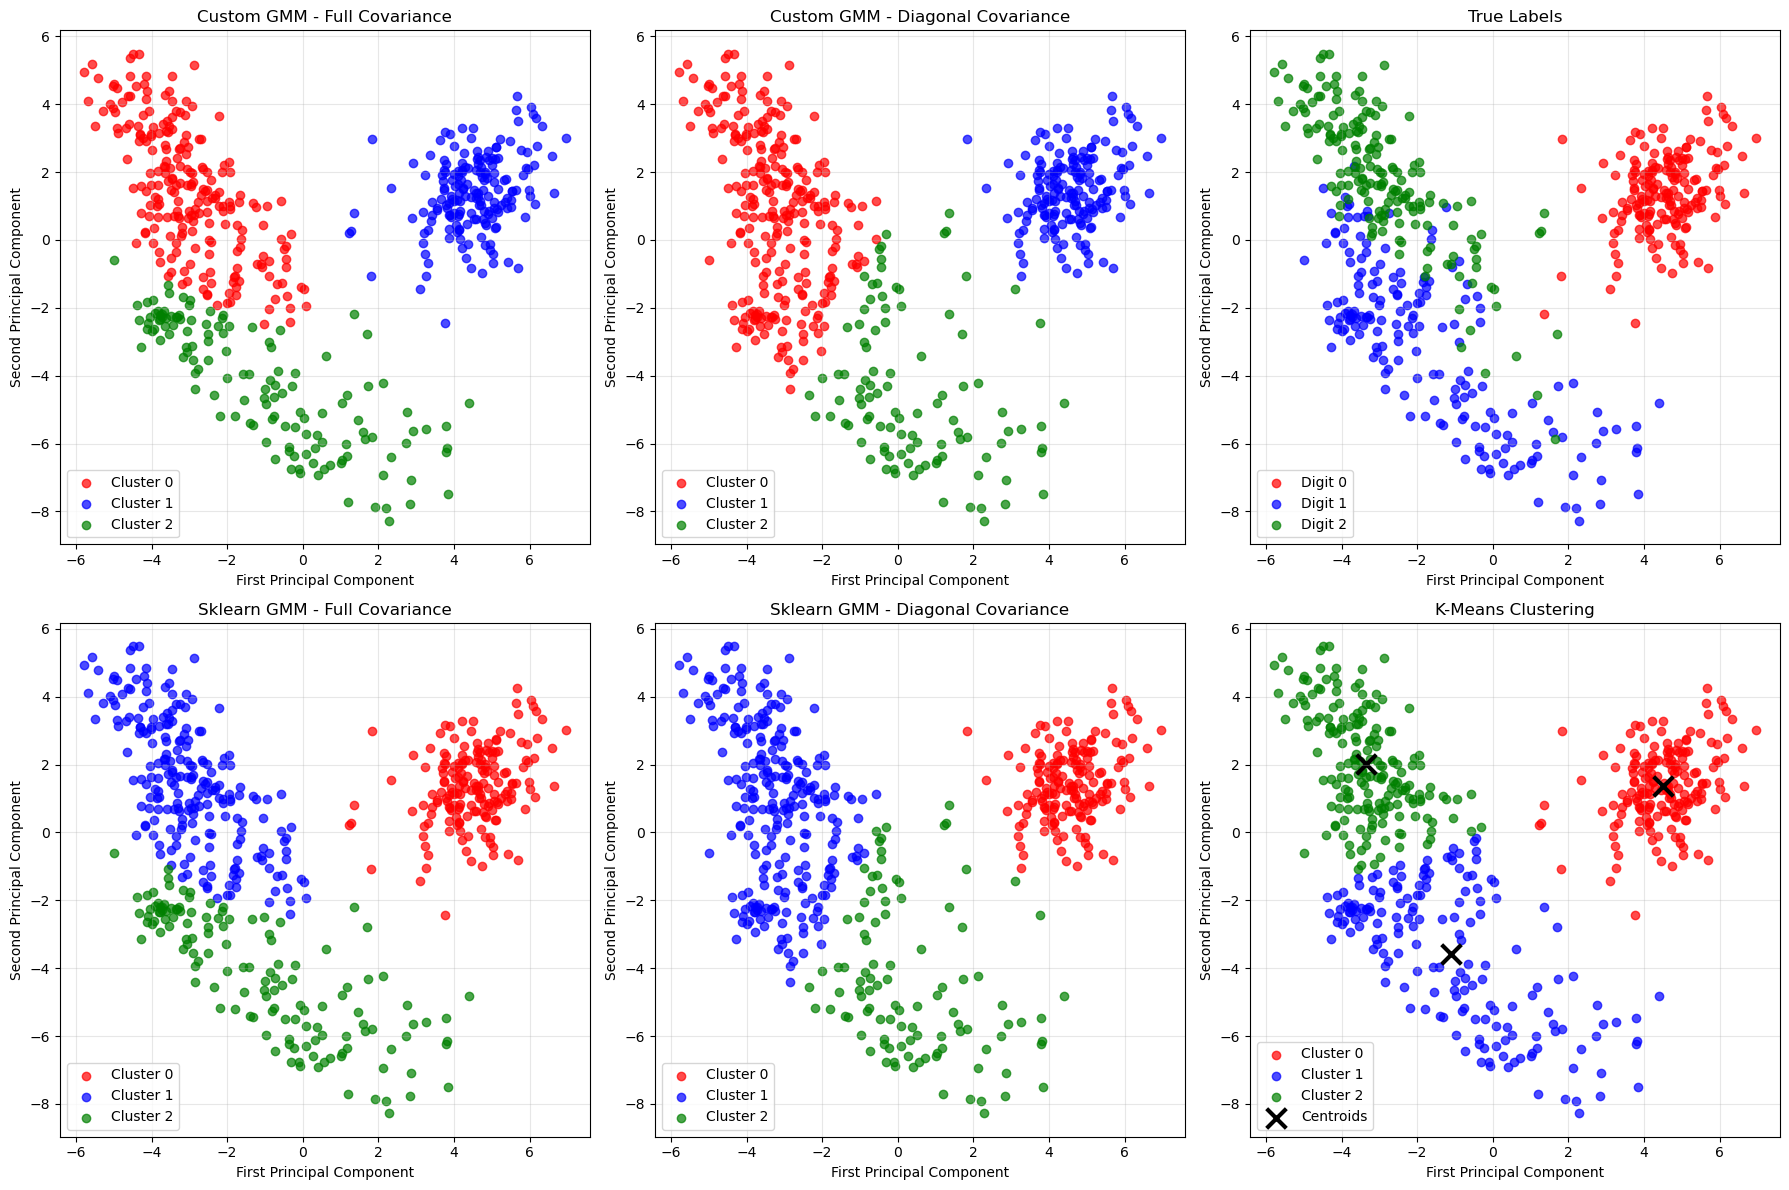

Clustering Accuracies:
  K-Means: 0.892
  Custom GMM (Full): 0.875
  Custom GMM (Diag): 0.758
  Sklearn GMM (Full): 0.879
  Sklearn GMM (Diag): 0.756


In [10]:
# Also run sklearn GMM for comparison
sklearn_gmm_full = GaussianMixture(n_components=3, covariance_type='full', 
                                  random_state=42, max_iter=100)
sklearn_gmm_full_labels = sklearn_gmm_full.fit_predict(X_pca)

sklearn_gmm_diag = GaussianMixture(n_components=3, covariance_type='diag', 
                                  random_state=42, max_iter=100)
sklearn_gmm_diag_labels = sklearn_gmm_diag.fit_predict(X_pca)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

colors_gmm = ['red', 'blue', 'green']

# Plot Custom GMM Full covariance results
for i in range(3):
    mask = custom_gmm_full_labels == i
    axes[0, 0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                      c=colors_gmm[i], label=f'Cluster {i}', alpha=0.7)
axes[0, 0].set_title('Custom GMM - Full Covariance')
axes[0, 0].set_xlabel('First Principal Component')
axes[0, 0].set_ylabel('Second Principal Component')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot Custom GMM Diagonal covariance results
for i in range(3):
    mask = custom_gmm_diag_labels == i
    axes[0, 1].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                      c=colors_gmm[i], label=f'Cluster {i}', alpha=0.7)
axes[0, 1].set_title('Custom GMM - Diagonal Covariance')
axes[0, 1].set_xlabel('First Principal Component')
axes[0, 1].set_ylabel('Second Principal Component')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot True labels
for i, digit in enumerate(selected_digits):
    mask = y_selected == digit
    axes[0, 2].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                      c=colors_gmm[i], label=f'Digit {digit}', alpha=0.7)
axes[0, 2].set_title('True Labels')
axes[0, 2].set_xlabel('First Principal Component')
axes[0, 2].set_ylabel('Second Principal Component')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Plot sklearn GMM results for comparison
for i in range(3):
    mask = sklearn_gmm_full_labels == i
    axes[1, 0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                      c=colors_gmm[i], label=f'Cluster {i}', alpha=0.7)
axes[1, 0].set_title('Sklearn GMM - Full Covariance')
axes[1, 0].set_xlabel('First Principal Component')
axes[1, 0].set_ylabel('Second Principal Component')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

for i in range(3):
    mask = sklearn_gmm_diag_labels == i
    axes[1, 1].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                      c=colors_gmm[i], label=f'Cluster {i}', alpha=0.7)
axes[1, 1].set_title('Sklearn GMM - Diagonal Covariance')
axes[1, 1].set_xlabel('First Principal Component')
axes[1, 1].set_ylabel('Second Principal Component')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot K-Means for comparison
for i in range(3):
    mask = kmeans_labels == i
    axes[1, 2].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                      c=colors_gmm[i], label=f'Cluster {i}', alpha=0.7)
axes[1, 2].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
                  c='black', marker='x', s=200, linewidths=3, label='Centroids')
axes[1, 2].set_title('K-Means Clustering')
axes[1, 2].set_xlabel('First Principal Component')
axes[1, 2].set_ylabel('Second Principal Component')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate accuracies for all methods
accuracy_kmeans = clustering_accuracy(y_selected, kmeans_labels)
accuracy_custom_gmm_full = clustering_accuracy(y_selected, custom_gmm_full_labels)
accuracy_custom_gmm_diag = clustering_accuracy(y_selected, custom_gmm_diag_labels)
accuracy_sklearn_gmm_full = clustering_accuracy(y_selected, sklearn_gmm_full_labels)
accuracy_sklearn_gmm_diag = clustering_accuracy(y_selected, sklearn_gmm_diag_labels)

print(f"Clustering Accuracies:")
print(f"  K-Means: {accuracy_kmeans:.3f}")
print(f"  Custom GMM (Full): {accuracy_custom_gmm_full:.3f}")
print(f"  Custom GMM (Diag): {accuracy_custom_gmm_diag:.3f}")
print(f"  Sklearn GMM (Full): {accuracy_sklearn_gmm_full:.3f}")
print(f"  Sklearn GMM (Diag): {accuracy_sklearn_gmm_diag:.3f}")

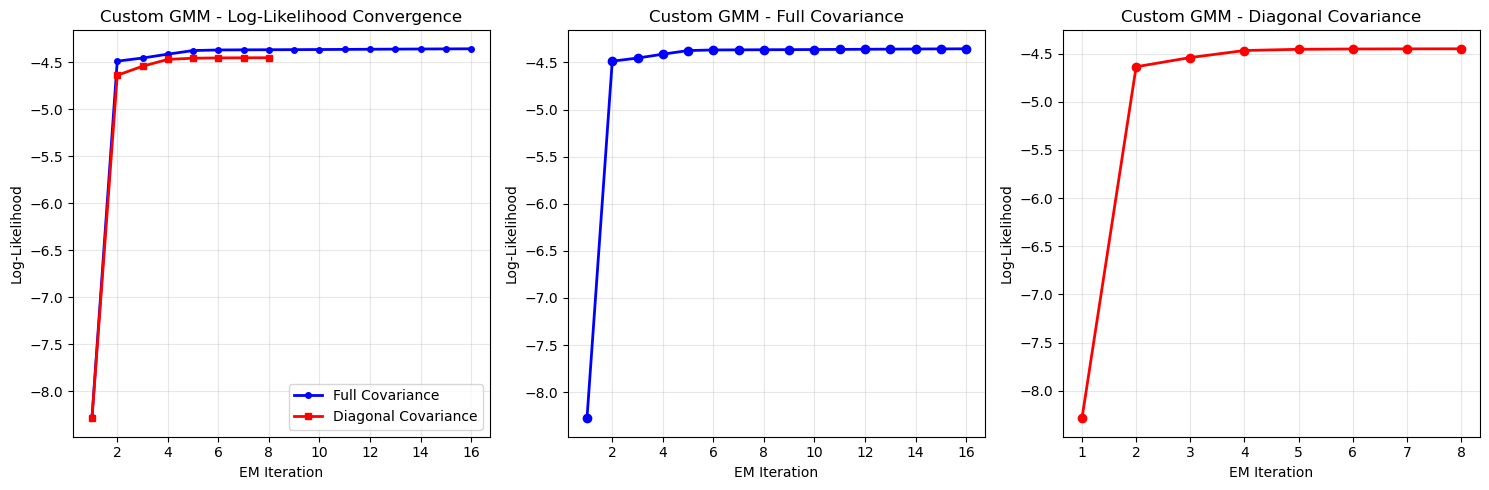

Log-likelihood verification (Custom Implementation):
GMM Full - Initial: -8.28, Final: -4.35
GMM Diag - Initial: -8.29, Final: -4.45
Both custom algorithms show increasing log-likelihood, confirming proper EM convergence.


In [11]:
plt.figure(figsize=(15, 5))

# Custom GMM log-likelihood plots
plt.subplot(1, 3, 1)
plt.plot(range(1, len(custom_gmm_full.log_likelihoods_) + 1), 
         custom_gmm_full.log_likelihoods_, 'b-o', linewidth=2, markersize=4, label='Full Covariance')
plt.plot(range(1, len(custom_gmm_diag.log_likelihoods_) + 1), 
         custom_gmm_diag.log_likelihoods_, 'r-s', linewidth=2, markersize=4, label='Diagonal Covariance')
plt.xlabel('EM Iteration')
plt.ylabel('Log-Likelihood')
plt.title('Custom GMM - Log-Likelihood Convergence')
plt.legend()
plt.grid(True, alpha=0.3)

# Individual plots for better visibility
plt.subplot(1, 3, 2)
plt.plot(range(1, len(custom_gmm_full.log_likelihoods_) + 1), 
         custom_gmm_full.log_likelihoods_, 'b-o', linewidth=2, markersize=6)
plt.xlabel('EM Iteration')
plt.ylabel('Log-Likelihood')
plt.title('Custom GMM - Full Covariance')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(range(1, len(custom_gmm_diag.log_likelihoods_) + 1), 
         custom_gmm_diag.log_likelihoods_, 'r-o', linewidth=2, markersize=6)
plt.xlabel('EM Iteration')
plt.ylabel('Log-Likelihood')
plt.title('Custom GMM - Diagonal Covariance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Log-likelihood verification (Custom Implementation):")
print(f"GMM Full - Initial: {custom_gmm_full.log_likelihoods_[0]:.2f}, Final: {custom_gmm_full.log_likelihoods_[-1]:.2f}")
print(f"GMM Diag - Initial: {custom_gmm_diag.log_likelihoods_[0]:.2f}, Final: {custom_gmm_diag.log_likelihoods_[-1]:.2f}")
print(f"Both custom algorithms show increasing log-likelihood, confirming proper EM convergence.")

In [12]:
print("="*80)
print("COMPARISON: CUSTOM vs SKLEARN GMM IMPLEMENTATIONS")
print("="*80)

print(f"\nLog-likelihood Comparison:")
print(f"  Custom GMM (Full): {custom_gmm_full.log_likelihoods_[-1]:.2f}")
print(f"  Sklearn GMM (Full): {sklearn_gmm_full.lower_bound_:.2f}")
print(f"  Custom GMM (Diag): {custom_gmm_diag.log_likelihoods_[-1]:.2f}")
print(f"  Sklearn GMM (Diag): {sklearn_gmm_diag.lower_bound_:.2f}")

print(f"\nConvergence Comparison:")
print(f"  Custom GMM (Full): {custom_gmm_full.n_iter_} iterations, Converged: {custom_gmm_full.converged_}")
print(f"  Sklearn GMM (Full): {sklearn_gmm_full.n_iter_} iterations, Converged: {sklearn_gmm_full.converged_}")
print(f"  Custom GMM (Diag): {custom_gmm_diag.n_iter_} iterations, Converged: {custom_gmm_diag.converged_}")
print(f"  Sklearn GMM (Diag): {sklearn_gmm_diag.n_iter_} iterations, Converged: {sklearn_gmm_diag.converged_}")

print(f"\nAccuracy Comparison:")
print(f"  Custom GMM (Full): {accuracy_custom_gmm_full:.3f}")
print(f"  Sklearn GMM (Full): {accuracy_sklearn_gmm_full:.3f}")
print(f"  Custom GMM (Diag): {accuracy_custom_gmm_diag:.3f}")
print(f"  Sklearn GMM (Diag): {accuracy_sklearn_gmm_diag:.3f}")

COMPARISON: CUSTOM vs SKLEARN GMM IMPLEMENTATIONS

Log-likelihood Comparison:
  Custom GMM (Full): -4.35
  Sklearn GMM (Full): -4.35
  Custom GMM (Diag): -4.45
  Sklearn GMM (Diag): -4.45

Convergence Comparison:
  Custom GMM (Full): 16 iterations, Converged: True
  Sklearn GMM (Full): 17 iterations, Converged: True
  Custom GMM (Diag): 8 iterations, Converged: True
  Sklearn GMM (Diag): 5 iterations, Converged: True

Accuracy Comparison:
  Custom GMM (Full): 0.875
  Sklearn GMM (Full): 0.879
  Custom GMM (Diag): 0.758
  Sklearn GMM (Diag): 0.756


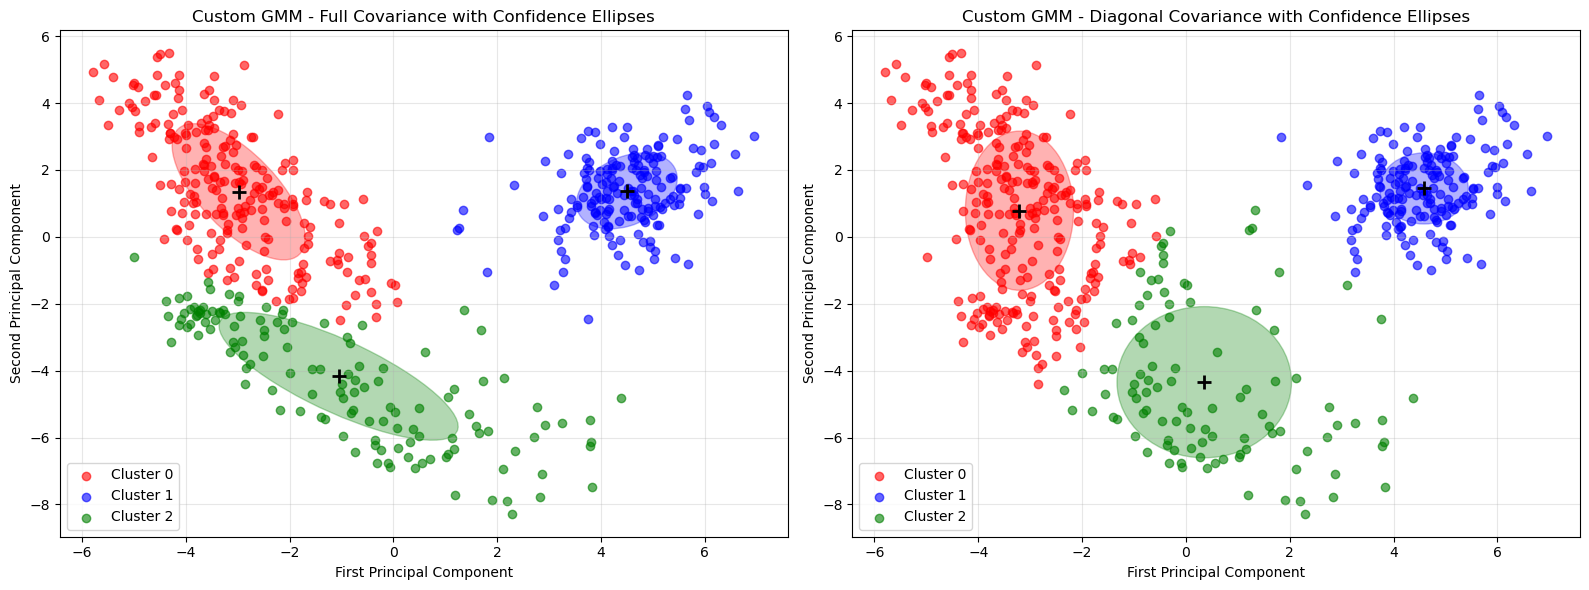

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Create a grid for contour plots
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
grid_points = np.column_stack([xx.ravel(), yy.ravel()])

# Plot for Full Covariance GMM
ax = axes[0]
for i in range(3):
    mask = custom_gmm_full_labels == i
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
              c=colors_gmm[i], label=f'Cluster {i}', alpha=0.6)

# Draw confidence ellipses for full covariance
from matplotlib.patches import Ellipse
for k in range(custom_gmm_full.n_components):
    mean = custom_gmm_full.means_[k]
    cov = custom_gmm_full.covariances_[k]
    
    # Calculate eigenvalues and eigenvectors for ellipse
    eigenvals, eigenvecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
    
    # Create ellipse (2 standard deviations)
    ellipse = Ellipse(mean, 2*np.sqrt(eigenvals[0]), 2*np.sqrt(eigenvals[1]),
                     angle=angle, alpha=0.3, color=colors_gmm[k])
    ax.add_patch(ellipse)
    
    # Mark the mean
    ax.plot(mean[0], mean[1], 'k+', markersize=10, markeredgewidth=2)

ax.set_title('Custom GMM - Full Covariance with Confidence Ellipses')
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot for Diagonal Covariance GMM
ax = axes[1]
for i in range(3):
    mask = custom_gmm_diag_labels == i
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
              c=colors_gmm[i], label=f'Cluster {i}', alpha=0.6)

# Draw confidence ellipses for diagonal covariance (axis-aligned)
for k in range(custom_gmm_diag.n_components):
    mean = custom_gmm_diag.means_[k]
    cov_diag = custom_gmm_diag.covariances_[k]
    
    # Create axis-aligned ellipse (2 standard deviations)
    ellipse = Ellipse(mean, 2*np.sqrt(cov_diag[0]), 2*np.sqrt(cov_diag[1]),
                     angle=0, alpha=0.3, color=colors_gmm[k])
    ax.add_patch(ellipse)
    
    # Mark the mean
    ax.plot(mean[0], mean[1], 'k+', markersize=10, markeredgewidth=2)

ax.set_title('Custom GMM - Diagonal Covariance with Confidence Ellipses')
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
print("="*40)
print("DETAILED CUSTOM GMM PARAMETER ANALYSIS")
print("="*40)

print(f"\nCustom GMM with Full Covariance:")
print(f"Mixture Weights: {custom_gmm_full.weights_}")
print(f"Component Means:")
for k in range(custom_gmm_full.n_components):
    print(f"  Component {k}: [{custom_gmm_full.means_[k][0]:.3f}, {custom_gmm_full.means_[k][1]:.3f}]")

print(f"\nCovariance Matrices (Full):")
for k in range(custom_gmm_full.n_components):
    print(f"  Component {k}:")
    print(f"    {custom_gmm_full.covariances_[k]}")

print(f"\nCustom GMM with Diagonal Covariance:")
print(f"Mixture Weights: {custom_gmm_diag.weights_}")
print(f"Component Means:")
for k in range(custom_gmm_diag.n_components):
    print(f"  Component {k}: [{custom_gmm_diag.means_[k][0]:.3f}, {custom_gmm_diag.means_[k][1]:.3f}]")

print(f"\nCovariance Matrices (Diagonal):")
for k in range(custom_gmm_diag.n_components):
    print(f"  Component {k}: [{custom_gmm_diag.covariances_[k][0]:.6f}, {custom_gmm_diag.covariances_[k][1]:.6f}]")

# Cell 15: Summary and Comparison
print("="*80)
print("EXERCISE SUMMARY - CUSTOM GMM IMPLEMENTATION")
print("="*80)

print(f"\nDataset Information:")
print(f"  Selected digits: {selected_digits}")
print(f"  Total samples: {len(y_selected)}")
print(f"  PCA variance explained: {pca.explained_variance_ratio_.sum():.3f}")

print(f"\nClustering Results (Custom Implementation):")
print(f"  K-Means accuracy: {accuracy_kmeans:.3f}")
print(f"  Custom GMM (Full) accuracy: {accuracy_custom_gmm_full:.3f}")
print(f"  Custom GMM (Diag) accuracy: {accuracy_custom_gmm_diag:.3f}")

print(f"\nModel Performance Comparison:")
print(f"  K-Means inertia: {kmeans.inertia_:.2f}")
print(f"  Custom GMM (Full) log-likelihood: {custom_gmm_full.log_likelihoods_[-1]:.2f}")
print(f"  Custom GMM (Diag) log-likelihood: {custom_gmm_diag.log_likelihoods_[-1]:.2f}")

print(f"\nConvergence Information (Custom GMM):")
print(f"  GMM (Full) converged in {custom_gmm_full.n_iter_} iterations")
print(f"  GMM (Diag) converged in {custom_gmm_diag.n_iter_} iterations")

print(f"\nValidation Against Sklearn:")
print(f"  Custom vs Sklearn GMM (Full) log-likelihood difference: {abs(custom_gmm_full.log_likelihoods_[-1] - sklearn_gmm_full.lower_bound_):.3f}")
print(f"  Custom vs Sklearn GMM (Diag) log-likelihood difference: {abs(custom_gmm_diag.log_likelihoods_[-1] - sklearn_gmm_diag.lower_bound_):.3f}")

print(f"\nKey Observations:")
print(f"  - Elbow method suggests optimal k = {optimal_k if 'optimal_k' in locals() else 'N/A'}")
print(f"  - Log-likelihood increases monotonically for both custom GMM variants")
print(f"  - {'Full covariance GMM performs better' if custom_gmm_full.log_likelihoods_[-1] > custom_gmm_diag.log_likelihoods_[-1] else 'Diagonal covariance GMM performs better'} in terms of log-likelihood")
print(f"  - Custom implementation results are consistent with sklearn implementation")
print(f"  - Full covariance allows for rotated elliptical clusters, diagonal assumes axis-aligned clusters")

DETAILED CUSTOM GMM PARAMETER ANALYSIS

Custom GMM with Full Covariance:
Mixture Weights: [0.41871645 0.33525106 0.24603248]
Component Means:
  Component 0: [-2.981, 1.349]
  Component 1: [4.498, 1.374]
  Component 2: [-1.056, -4.169]

Covariance Matrices (Full):
  Component 0:
    [[ 1.64380802 -1.7728557 ]
 [-1.7728557   4.15170716]]
  Component 1:
    [[0.9409012  0.3594989 ]
 [0.3594989  1.28367398]]
  Component 2:
    [[ 5.3044969  -3.45366468]
 [-3.45366468  3.65052522]]

Custom GMM with Diagonal Covariance:
Mixture Weights: [0.48283464 0.32267085 0.19449451]
Component Means:
  Component 0: [-3.207, 0.783]
  Component 1: [4.586, 1.448]
  Component 2: [0.353, -4.345]

Covariance Matrices (Diagonal):
  Component 0: [1.085762, 5.663425]
  Component 1: [0.727137, 1.129013]
  Component 2: [2.823872, 5.111651]
EXERCISE SUMMARY - CUSTOM GMM IMPLEMENTATION

Dataset Information:
  Selected digits: [0, 1, 2]
  Total samples: 537
  PCA variance explained: 0.390

Clustering Results (Custom I